### TODO
- Everything
- Drop users that have rated very few movies -> How to decide the threshold?
- Define the best approach to the collaborative filtering (model-based or memory-based)
- Build the recommender system (can it be as simple as kNN?)

### DONE
- File loading and creation of the DataFrame

In [1]:
# Imports
import os
import gc
import sys
import math

# from pathlib import Path
import pandas as pd
import numpy as np
from numpy.random import default_rng
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from surprise import Reader, Dataset, SVD, KNNWithMeans, KNNBasic
from surprise.model_selection import cross_validate, GridSearchCV


# # Not being used yet.
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, StratifiedKFold
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.cluster import KMeans
# from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.pipeline import Pipeline

# from scipy.sparse import csr_matrix

# from scipy.spatial import Voronoi, voronoi_plot_2d
# from imblearn.over_sampling import SMOTE

sns.set_theme(style="darkgrid")

In [2]:
# Read Movie Titles file
def readMovieTitle(file_path):
    data_dict = {'Movie_Id' : [], 'Release_Year' : [], 'Title' : []}
    data_file = open(file_path, "r", encoding='ISO-8859-1')
    for line in data_file:            
        id, year, title = line.split(',', 2)
        data_dict['Movie_Id'].append(id)
        data_dict['Release_Year'].append(year)
        data_dict['Title'].append(title.rstrip('\n'))
    data_file.close()
            
    return pd.DataFrame(data_dict)

In [3]:
# The dataset is very large, so there's a flag to load only a handful of rows if necessary
# First 1M lines takes 0.2s to load, the whole dataset takes almost 2 minutes
cid_list = {}
def readFile(file_path, rows = 1000000, flag = False):
    data_dict = {'Cust_Id' : [], 'Movie_Id' : [], 'Rating' : [], 'Date' : []}
    data_file = open(file_path, "r")
    count = 0
    for line in data_file:
        count += 1
        if flag and (count > rows):
            break
            
        if ':' in line:
            movieId = line[:-2] # remove the last character ':'
            movieId = int(movieId)
        else:
            customerID, rating, date = line.split(',')
            if (customerID not in cid_list):
                cid_list[customerID] = 1
            else:
                cid_list[customerID] += 1
            data_dict['Cust_Id'].append(customerID)
            data_dict['Movie_Id'].append(movieId)
            data_dict['Rating'].append(rating)
            data_dict['Date'].append(date.rstrip("\n"))
    data_file.close()
            
    return pd.DataFrame(data_dict)

In [4]:
# Load the title of the movies into a dataframe
df_title = readMovieTitle('data/movie_titles.csv')
df_title['Movie_Id'] = df_title['Movie_Id'].astype(int)
df_title.head(10)
# df_title.loc[df_title['Movie_Id'] == 1]

,Movie_Id,Release_Year,Title
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW
5,6,1997,Sick
6,7,1992,8 Man
7,8,2004,What the #$*! Do We Know!?
8,9,1991,Class of Nuke 'Em High 2
9,10,2001,Fighter


In [5]:
# Loading the user data
# User ID, Movie ID, Rating and Date
flag_limit = False
df1 = readFile('data/combined_data_1.txt', flag = flag_limit)
df2 = readFile('data/combined_data_2.txt', flag = flag_limit)
df3 = readFile('data/combined_data_3.txt', flag = flag_limit)
df4 = readFile('data/combined_data_4.txt', flag = flag_limit)
# Transform everything to INT, occupies less RAM.
df1['Rating'] = df1['Rating'].astype(int)
df2['Rating'] = df2['Rating'].astype(int)
df3['Rating'] = df3['Rating'].astype(int)
df4['Rating'] = df4['Rating'].astype(int)
df1['Cust_Id'] = df1['Cust_Id'].astype(int)
df2['Cust_Id'] = df2['Cust_Id'].astype(int)
df3['Cust_Id'] = df3['Cust_Id'].astype(int)
df4['Cust_Id'] = df4['Cust_Id'].astype(int)

In [6]:
# Creation of the DataFrame with all the data
df = df1.copy()
df = pd.concat([df1, df2, df3, df4])
df.index = np.arange(0,len(df))
df.head(10)
# Drop everything but the essential information
df = df.loc[:, ['Cust_Id', 'Movie_Id', 'Rating']]
original = df

del df1, df2, df3, df4, # df_title
gc.collect()

0

In [ ]:
df.groupby('Movie_Id')['Rating'].count().sort_values(ascending=True).mean()

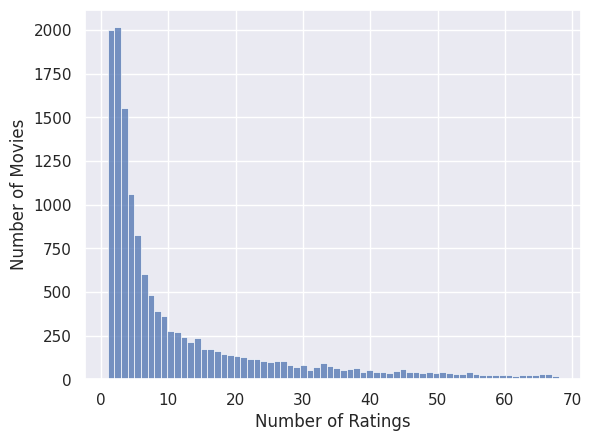

In [22]:
mr = df.groupby('Movie_Id')['Rating'].count().sort_values(ascending=True).head(14000)

ax = sns.histplot(data=mr)
ax.bar_label(ax.containers[0])
plt.axis('on')
plt.xlabel('Number of Ratings')
plt.xscale('linear')
plt.ylabel('Number of Movies')
plt.show()

In [23]:
# Number of unique movies
movie_count = df['Movie_Id'].nunique()

# Number of unique customers
cust_count = df['Cust_Id'].nunique()

# Number of ratings
rating_count = df['Cust_Id'].count()

# How many ratings for each value (1-5)
rating_dist = df['Rating'].value_counts().sort_index()

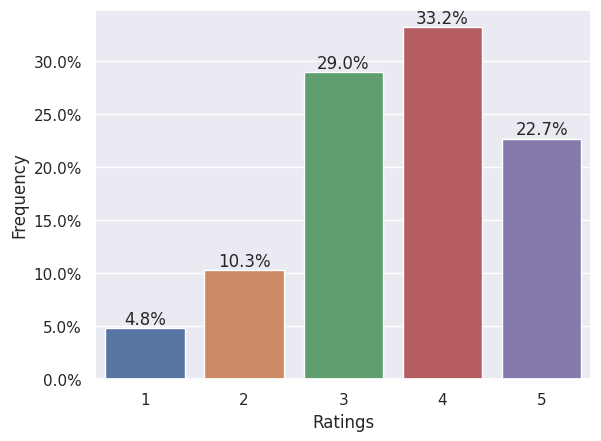

In [24]:
# Histogram of the frequency of ratings
rd = [(i/sum(rating_dist)*100) for i in rating_dist]

ax = sns.barplot(x = np.arange(1,len(rd)+1), y = rd)
ax.bar_label(ax.containers[0], fmt = '%.1f%%')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.axis('on')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.show()

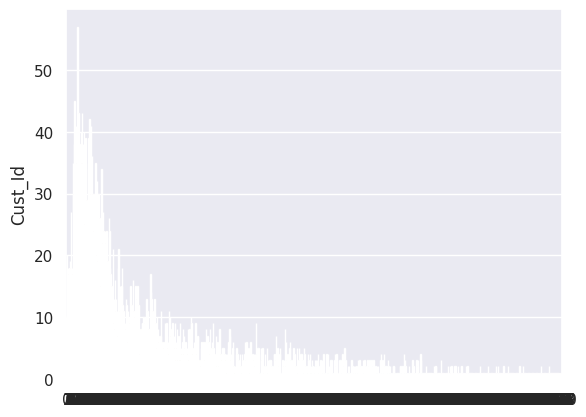

In [25]:
# Histogram of the frequency of reviews by users
# Not used in the final report
cust_rating_dist = df['Cust_Id'].value_counts().sort_values()

crd = cust_rating_dist.value_counts().sort_index()

ax = sns.barplot(x = np.arange(len(crd)), y = crd) 
plt.show()

In [8]:
# Reducing the dataset so it works with reasonable RAM consumption and run times
drop_percentage = 0.99
cid_as_int = list(map(lambda x: int(x), cid_list.keys()))
cid_as_str = list(map(lambda x: x, cid_list.keys()))
cid_df = pd.DataFrame(data={"Cust_Id": cid_as_int})
 
# print(cid_df)
arr_cid_to_drop = default_rng().choice(cid_df.index, size=(math.floor(len(cid_df)*drop_percentage)), replace=False)
cid_df.drop(index=arr_cid_to_drop, inplace=True)
mask1 = df["Cust_Id"].isin(cid_df["Cust_Id"].tolist())
df = df[df["Cust_Id"].isin(cid_df["Cust_Id"].tolist())]
# df.info()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 991747 entries, 310 to 100480478
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   Cust_Id   991747 non-null  int64
 1   Movie_Id  991747 non-null  int64
 2   Rating    991747 non-null  int64
dtypes: int64(3)
memory usage: 30.3 MB


After the successful loading of the data into a single large dataframe, now it's time to understand the data and do a little bit of a clean up (delete rows with NaN values, look for duplicates, drop unnecessary columns etc.)

In [59]:
# General format of the Dataframe
df.head(10)

,Cust_Id,Movie_Id,Rating
0,1488844,1,3
1,822109,1,5
2,885013,1,4
3,30878,1,4
4,823519,1,3
5,893988,1,3
6,124105,1,4
7,1248029,1,3
8,1842128,1,4
9,2238063,1,3


In [60]:
df.shape

(999775, 3)

In [61]:
# Check the type of the variables.
# Here we identify that some are loaded as a type we don't want and thus need to transform it
# Int occupies less memory
df.dtypes

Cust_Id     int64
Movie_Id    int64
Rating      int64
dtype: object

In [10]:
# KNN
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)
trainset = data.build_full_trainset()

param = {'name':'cosine', 'user_based':False}
knn = KNNBasic(sim_options=param)
knn.fit(trainset)

cross_validate(knn, data, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0068  1.0068  1.0050  1.0079  1.0084  1.0070  0.0012  
MAE (testset)     0.7921  0.7917  0.7899  0.7922  0.7927  0.7917  0.0010  
Fit time          33.14   33.09   33.13   33.13   33.41   33.18   0.12    
Test time         75.02   74.10   77.04   74.07   75.10   75.07   1.08    


{'test_rmse': array([1.00681081, 1.00680004, 1.00496386, 1.00793601, 1.0084302 ]),
 'test_mae': array([0.7921433 , 0.79171482, 0.78991154, 0.79221607, 0.79267613]),
 'fit_time': (33.14222526550293,
  33.091511964797974,
  33.13217043876648,
  33.130717039108276,
  33.408663511276245),
 'test_time': (75.02432560920715,
  74.1037483215332,
  77.04302334785461,
  74.0657901763916,
  75.10056066513062)}

In [11]:
df.head()

,Cust_Id,Movie_Id,Rating
310,1682104,1,4
311,16272,1,4
434,1806515,1,3
670,1806515,2,3
811,1394444,3,5


In [13]:
# show results on random user
# user_id has to be a not-dropped value as seen in the df.head above
# We pick the first person in the table, for convenience
userId = df.at[df.index[0], "Cust_Id"]
random_user = df_title.copy()
random_user = random_user.reset_index()

random_user['Estimate_Score'] = random_user['Movie_Id'].apply(lambda x: knn.predict(userId, x).est)

random_user = random_user.sort_values('Estimate_Score', ascending=False)
print(random_user[['Movie_Id', 'Title', 'Estimate_Score']].head(20))

       Movie_Id                                              Title  \
13781     13782                        38 Special: Live at Sturgis   
11077     11078        Allman Brothers: Live at the Beacon Theatre   
980         981                             How I Got into College   
134         135                  GTO: Great Teacher Onizuka: Set 2   
8791       8792                        Undergrads: Freshman Season   
7949       7950                                   Le Professionnel   
7379       7380              The String Cheese Incident: Evolution   
12775     12776  The String Cheese Incident: Waiting for the Sn...   
16309     16310                America's Stone Age Explorers: Nova   
5478       5479         Shane McGowan: If I Should Fall From Grace   
14417     14418     The Good, the Bad and the Ugly: Bonus Material   
12116     12117                             Cruise Hawaii & Tahiti   
13638     13639        The Man Show Presents: Girls on Trampolines   
5449       5450  Wac

In [14]:
# basic svd, default parameters
svd = SVD()
svd.fit(trainset)
cross_validate(svd, data, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9034  0.9034  0.9038  0.9025  0.9023  0.9031  0.0006  
MAE (testset)     0.7027  0.7022  0.7015  0.7008  0.7005  0.7015  0.0008  
Fit time          9.86    10.01   10.04   9.81    9.78    9.90    0.10    
Test time         2.00    1.95    2.48    2.48    1.99    2.18    0.25    


{'test_rmse': array([0.90337492, 0.90341251, 0.90379564, 0.90252304, 0.90234748]),
 'test_mae': array([0.70270163, 0.70219974, 0.70147032, 0.7007746 , 0.70053078]),
 'fit_time': (9.856375217437744,
  10.005193948745728,
  10.035174369812012,
  9.813184022903442,
  9.778027296066284),
 'test_time': (1.9950575828552246,
  1.945230484008789,
  2.4814341068267822,
  2.477712392807007,
  1.9890704154968262)}

In [20]:
# show results on random user
random_user = df_title.copy()
random_user = random_user.reset_index()

random_user['Estimate_Score'] = random_user['Movie_Id'].apply(lambda x: svd.predict(userId, x).est)

random_user = random_user.sort_values('Estimate_Score', ascending=False)
print(random_user[['Movie_Id', 'Title', 'Estimate_Score']].head(20))

       Movie_Id                                              Title  \
3455       3456                                     Lost: Season 1   
7056       7057  Lord of the Rings: The Two Towers: Extended Ed...   
7229       7230  The Lord of the Rings: The Fellowship of the R...   
13555     13556                            The West Wing: Season 2   
2101       2102                             The Simpsons: Season 6   
14960     14961  Lord of the Rings: The Return of the King: Ext...   
7568       7569                             Dead Like Me: Season 2   
7832       7833                     Arrested Development: Season 2   
4426       4427                            The West Wing: Season 3   
10777     10778                                   Scrubs: Season 1   
7748       7749                     Curb Your Enthusiasm: Season 4   
14549     14550          The Shawshank Redemption: Special Edition   
12292     12293                                      The Godfather   
2802       2803     